## Ultimate Challenge  
  
I start by loading packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import permutation_test_score
%matplotlib inline

# Part 1  
  
I load the json time stamps and aggregate the times by 15 minute intervals, and additionally extract information about the day of the week and hour of the day:

In [2]:
logins = pd.read_json("logins.json")
logins["count"] = 1
logins.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [3]:
login_counts = logins.groupby(pd.Grouper(key='login_time', freq='900s')).count()
login_counts['day_of_week'] = (pd.DatetimeIndex(login_counts.index).dayofweek)
login_counts['hour'] = (pd.DatetimeIndex(login_counts.index).hour)
login_counts.head()

,count,day_of_week,hour
login_time,,,
1970-01-01 20:00:00,2,3,20
1970-01-01 20:15:00,6,3,20
1970-01-01 20:30:00,9,3,20
1970-01-01 20:45:00,7,3,20
1970-01-01 21:00:00,1,3,21


Plotting the number of logins over time shows a cyclic pattern that coincides with larger numbers of logins on the weekends and also late at night:

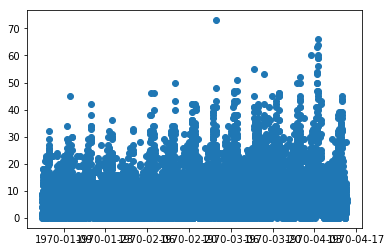

In [4]:
plt.plot_date(date2num(list(login_counts.index)), login_counts["count"].values)

In [5]:
login_counts["day_of_week"][login_counts["count"] > 20].value_counts()

5    310
6    258
4    169
3     92
2     64
1     56
0     30
Name: day_of_week, dtype: int64

In [6]:
login_counts["hour"][login_counts["count"] > 20].value_counts()

1     110
2     106
22    102
4     100
11     90
3      87
23     83
0      73
21     60
5      43
12     31
16     18
20     13
15     11
14     11
17     10
19      9
13      8
18      7
10      5
6       2
Name: hour, dtype: int64

# Part 2  
  
As a metric to evaluate the proposal, I suggest using the number of times a driver crosses the toll bridge during non-trip driving. If drivers are acutally crossing the bridge more when they have access to the reinbursment, it suggests that they are more often splitting time between cities. To carry out the experiment, I suggest that Ultimate randomly assign drivers, balanced by "primary city of driving" (e.g. the city they typically drive in) to either recieve or not recieve a promotion that offers to reinburse toll costs. Ultimate can then log how often driver who both recieve or not this promotion cross the toll bridge. At the end of the experiment, the difference in number of crossings for each group can be tested using poisson regression taking into account number of hours driven and potentially other factors that might impact crossing unrelated to the promotion. If there is a higher rate of crossing for the group recieving the promotion, Ultimate might consider implementing the promotion for all drivers.

# Part 3  
  
I read in the data file:

In [7]:
with open("ultimate_data_challenge.json") as f:
    pred_data = json.load(f)

pred_data = pd.DataFrame(pred_data)
pred_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [8]:
min(pd.to_datetime(pred_data["last_trip_date"]))

Timestamp('2014-01-01 00:00:00')

In [9]:
max(pd.to_datetime(pred_data["last_trip_date"]))

Timestamp('2014-07-01 00:00:00')

Although it is a bit ambiguous, I am going to assume that for the purposes of "active" status, having taken a trip in the previous 30 days means the 30 days previous to July 2014. Roughly 37% of users are retained at 6 months in this cohort:

In [10]:
active_ind = (pd.to_datetime(pred_data["last_trip_date"]) < pd.to_datetime(max(pred_data["last_trip_date"])) - pd.Timedelta("30 days")) + 0
active_ind.value_counts()

1    31196
0    18804
Name: last_trip_date, dtype: int64

In [11]:
active_ind.value_counts()[0]/len(active_ind)

0.37608000000000003

In [12]:
min(pd.to_datetime(pred_data["signup_date"]))

Timestamp('2014-01-01 00:00:00')

In [13]:
max(pd.to_datetime(pred_data["signup_date"]))

Timestamp('2014-01-31 00:00:00')

The purpose of the analysis is to develop a model that predicts active status at 6 months. The users in this cohort were admitted throughout January, so not have have been enrolled for strictly the same amount of time, nor is the active status calculated above strictly at 6 months for all users. I omit consideration of each users exact signup date because they are all restricted to the same month. I also omit date-based features based on signup date because presumably the model will be used in times outside January so it isn't clear that predictions based on these features would generalize. I also omit the variable for last trip date because it leaks the target variable. This leaves the following variables as valid predictors:

In [14]:
pred_features = pred_data.iloc[:,[0,1,2,3,4,6,8,9,10,11]]
pred_features.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,14,False,82.4


Depending on when the model is intended to be used, some of these features are arguably not valid. For example, if the ratings, precentages or ultimate black user status use trips conducted very close to the end of the 6 months then they relationship between these features and the target may be different than the relationship would be at prediction time. I assume that the features have been calculated in such a way that they only use information that will be available at prediction time.

In [15]:
pred_features.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [16]:
pred_features.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

I one-hot encode the categorical features:

In [17]:
pred_features.loc[:,"ultimate_black_user"] = pred_features.loc[:,"ultimate_black_user"] + 0
pred_features.loc[:,"phone"] = (pred_features.loc[:,"phone"] == "iPhone") + 0
pred_features_city = pred_features.loc[:,"city"]
pred_features.loc[:,"city"] = (pred_features.loc[:,"city"] == "Winterfell") + 0
pred_features.loc[:,"city_2"] = (pred_features_city == "Astapor") + 0

/Users/scottpiraino/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/scottpiraino/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [18]:
pred_features.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_2
0,3.67,5.0,4.7,1.10,0,1,15.4,4,1,46.2,0
1,8.26,5.0,5.0,1.00,0,0,0.0,0,0,50.0,1
2,0.77,5.0,4.3,1.00,0,1,0.0,3,0,100.0,1
3,2.36,4.9,4.6,1.14,0,1,20.0,9,1,80.0,0
4,3.13,4.9,4.4,1.19,1,0,11.8,14,0,82.4,0


Some values are missing. Missing values are sometimes informative for prediction. One way to enable learning algorithms to capture this is to assign mssing values a unique value. I assign mssing values the value -1.

In [19]:
pred_features = pred_features.fillna(-1)

I fit a random forest evaluate it with a permutation test on its cross validated performance:

In [20]:
rf = RandomForestClassifier(max_depth = 5)
score, permutation_scores, pvalue = permutation_test_score(rf, pred_features.values, active_ind.values, scoring="accuracy", cv = 5, n_permutations = 100, n_jobs=1)

In [21]:
permutation_scores

array([ 0.62379999,  0.62394   ,  0.62386001,  0.6238    ,  0.62378   ,
        0.62381999,  0.62369999,  0.62382   ,  0.62386   ,  0.62392   ,
        0.62384   ,  0.62404   ,  0.62377999,  0.62395999,  0.62374   ,
        0.62386001,  0.62411999,  0.6238    ,  0.62374   ,  0.62384001,
        0.62392   ,  0.62384   ,  0.62382   ,  0.62376   ,  0.62376   ,
        0.62388   ,  0.62388   ,  0.62398   ,  0.62388   ,  0.62377999,
        0.62372   ,  0.624     ,  0.62382   ,  0.62364   ,  0.624     ,
        0.62406   ,  0.62396   ,  0.6239    ,  0.62394   ,  0.62374   ,
        0.6238    ,  0.6239    ,  0.62372   ,  0.6237    ,  0.62374001,
        0.62374   ,  0.62384   ,  0.62384   ,  0.62392   ,  0.62375999,
        0.62394   ,  0.62367999,  0.62358   ,  0.62377999,  0.62378   ,
        0.62388   ,  0.62386   ,  0.62371999,  0.62380001,  0.62382   ,
        0.62396   ,  0.62379999,  0.62396   ,  0.62362   ,  0.62381999,
        0.62385999,  0.62388   ,  0.6239    ,  0.62376001,  0.62

In [22]:
score

0.75450023301420233

In [23]:
pvalue

0.0099009900990099011

In [24]:
active_ind.value_counts()[1]/len(active_ind)

0.62392000000000003

The model has a cross validation accuracy of 0.74, relative to the ~0.62 that can be achieved by random guessing or predicting all users will be inactive. This model could be used to forcast the number of users likely to be active at in the future for planning purposes (e.g. to estimate server loads and prepare resources). Some people may also be tempted to use it for targeting, meaning using the predictions to decide whether or not to send users a promotion or advertisement. I think this is one possible use, but it also relies on strong and often untested assumptions about the causal effect of the potential intervention (e.g. sending a promotion).